In [1]:
%matplotlib inline

# Standard Package Imports
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import sparse
from numpy.random import default_rng
import os

# Custom Imports
import pgmax.contrib.interface.node_classes as node_classes
import pgmax.contrib.mpbp.mpbp_varnode_array as mpbp_varnode_array

## Setting up Image and Factor Graph

Text(0.5, 1.0, 'Label Image (yellow is higher depth than purple)')

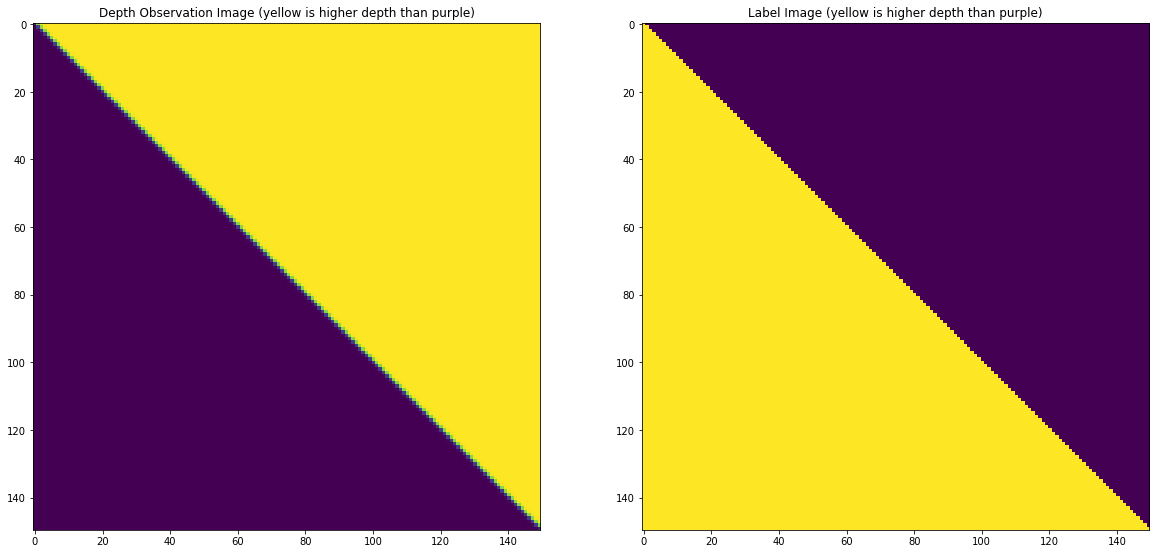

In [2]:
# Set random seed for rng
rng = default_rng(23)

# Create a synthetic depth image for testing purposes
im_size = 150
depth_img = 5.0 * np.ones((im_size, im_size))
depth_img[np.tril_indices(im_size, 0)] = 1.0 # This sets the lower triangle of the image to 1's 
depth_img = gaussian_filter(depth_img, sigma=0.5) # Filter the depth image for realistic noise simulation?
labels_img = np.zeros((im_size, im_size), dtype=np.int32)
labels_img[np.tril_indices(im_size, 0)] = 1

# Plot the depth and label images
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(depth_img)
ax[0].set_title('Depth Observation Image (yellow is higher depth than purple)')
ax[1].imshow(labels_img)
ax[1].set_title('Label Image (yellow is higher depth than purple)')

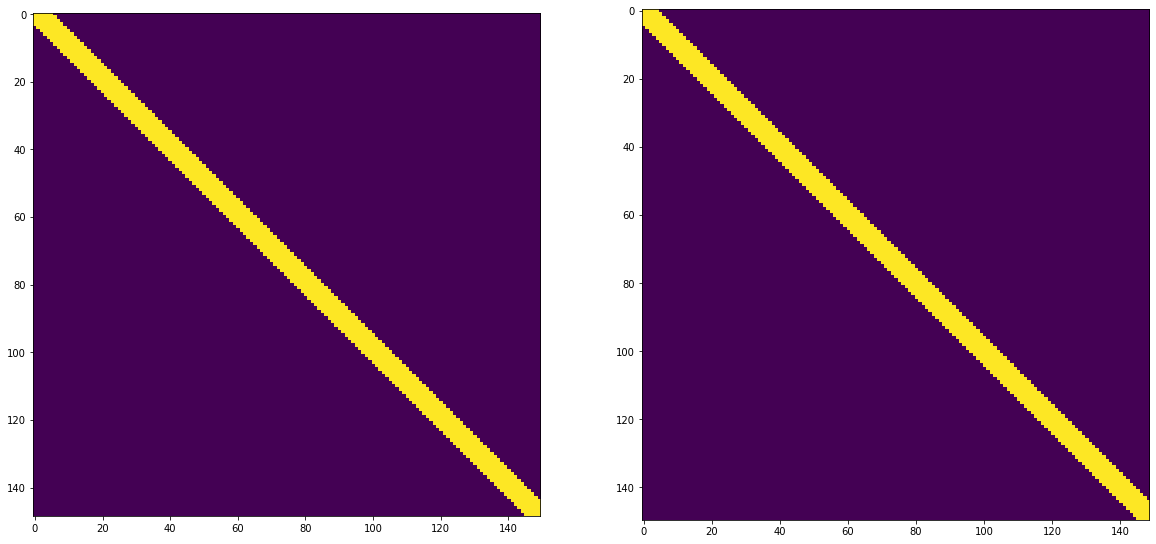

In [3]:
M, N = depth_img.shape
# Compute dI/dx (horizontal derivative)
horizontal_depth_differences = depth_img[:-1] - depth_img[1:]
# Compute dI/dy (vertical derivative)
vertical_depth_differences = depth_img[:, :-1] - depth_img[:, 1:]

# The below code block assigns values for the orientation of every horizontally-oriented cut
# It creates a matrix to represent each of the horizontal cuts in the image graph (there will be (M-1, N) possible cuts)
# Assigning a cut of 1 points to the left and a cut of 2 points to the right. A cut of 0 indicates an 'off; state
horizontal_oriented_cuts = np.zeros((M - 1, N))
horizontal_oriented_cuts[horizontal_depth_differences < 0] = 1
horizontal_oriented_cuts[horizontal_depth_differences > 0] = 2

# The below code block assigns values for the orientation of every vertically-oriented cut
# It creates a matrix to represent each of the vertical cuts in the image graph (there will be (M-1, N) possible cuts)
# Assigning a cut of 1 points up and a cut of 2 points down. A cut of 0 indicates an 'off' state
vertical_oriented_cuts = np.zeros((M, N - 1))
vertical_oriented_cuts[vertical_depth_differences < 0] = 1
vertical_oriented_cuts[vertical_depth_differences > 0] = 2
gt_has_cuts = np.zeros((2, M, N))
gt_has_cuts[0, :-1] = horizontal_oriented_cuts
gt_has_cuts[1, :, :-1] = vertical_oriented_cuts

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(horizontal_oriented_cuts)
ax[1].imshow(vertical_oriented_cuts)

In [4]:
# Helper function to easily generate a list of valid configurations for a given suppression diameter
def create_valid_suppression_config_arr(suppression_diameter):
    valid_suppressions_list = []
    base_list = [0] * suppression_diameter
    valid_suppressions_list.append(base_list)
    for idx in range(suppression_diameter):
        new_valid_list1 = base_list[:]
        new_valid_list2 = base_list[:]
        new_valid_list1[idx] = 1
        new_valid_list2[idx] = 2
        valid_suppressions_list.append(new_valid_list1)
        valid_suppressions_list.append(new_valid_list2)
    return np.array(valid_suppressions_list)

In [5]:
# Creating the Factor Graph by instantiating Factor and Variable Nodes and writing out neighbors
factors_dict = {}
# The Factors for the laterals model will form a (M-1) x (N-1) grid
for row in range(M - 1):
    for col in range(N - 1):
        factor_name = f"F{row},{col}"
        curr_factor = node_classes.FactorNode(factor_name)
        factors_dict[factor_name] = curr_factor

vars_list = []
vars_dict = {}
factors_neighbors_dict = {}
NUM_VAR_STATES = 3
# Now that we have factors in place, we can create variables and assign neighbor relations
# NOTE: The naming scheme for variables is not thorough. For instance, V1,1,down should be the same node as
# V2,1,up however this is not the case because a variable can only have one name...
for row in range(M - 1):
    for col in range(N - 1):
        if col == 0:
            left_var_name = f"V{row},{col},left"
            left_var = node_classes.VariableNode(left_var_name, NUM_VAR_STATES)
            left_var.add_neighbor(factors_dict[f"F{row},{col}"])
            factors_neighbors_dict[f"F{row},{col}"] = factors_neighbors_dict.get(
                f"F{row},{col}", []
            ) + [left_var]
            vars_list.append(left_var)
            vars_dict[left_var_name] = left_var

        if row == 0:
            up_var_name = f"V{row},{col},up"
            up_var = node_classes.VariableNode(up_var_name, NUM_VAR_STATES)
            up_var.add_neighbor(factors_dict[f"F{row},{col}"])
            factors_neighbors_dict[f"F{row},{col}"] = factors_neighbors_dict.get(
                f"F{row},{col}", []
            ) + [up_var]
            vars_list.append(up_var)
            vars_dict[up_var_name] = up_var

        right_var_name = f"V{row},{col},right"
        right_var = node_classes.VariableNode(right_var_name, NUM_VAR_STATES)
        right_var.add_neighbor(factors_dict[f"F{row},{col}"])
        factors_neighbors_dict[f"F{row},{col}"] = factors_neighbors_dict.get(
            f"F{row},{col}", []
        ) + [right_var]
        # If the right_var is not at the last column, it will also have another factor neighbor
        if col != N - 2:
            right_var.add_neighbor(factors_dict[f"F{row},{col+1}"])
            factors_neighbors_dict[f"F{row},{col+1}"] = factors_neighbors_dict.get(
                f"F{row},{col+1}", []
            ) + [right_var]
        vars_list.append(right_var)
        vars_dict[right_var_name] = right_var

        down_var_name = f"V{row},{col},down"
        down_var = node_classes.VariableNode(down_var_name, NUM_VAR_STATES)
        down_var.add_neighbor(factors_dict[f"F{row},{col}"])
        factors_neighbors_dict[f"F{row},{col}"] = factors_neighbors_dict.get(
            f"F{row},{col}", []
        ) + [down_var]
        # If the down_var is not at the last row, it will also have another factor neighbor
        if row != M - 2:
            down_var.add_neighbor(factors_dict[f"F{row+1},{col}"])
            factors_neighbors_dict[f"F{row+1},{col}"] = factors_neighbors_dict.get(
                f"F{row+1},{col}", []
            ) + [down_var]
        vars_list.append(down_var)
        vars_dict[down_var_name] = down_var

        # To make sure the factor neighbors are ALWAYS in the same order (i.e [left_var, up_var, right_var, down_var]),
        # we need to perform a swap on factor_neighbors_dict for all rows except the first in the graph
        if row != 0:
            neighbors_list = factors_neighbors_dict[f"F{row},{col}"]
            zero_index_neighbor = neighbors_list[0]
            neighbors_list[0] = neighbors_list[1]
            neighbors_list[1] = zero_index_neighbor
            factors_neighbors_dict[f"F{row},{col}"] = neighbors_list

# Now that we have all the variables and know their connections with the existing factors are correct, we can define the suppression factors
# as well as their connections
SUPPRESSION_DIAMETER = 9
suppression_factors_list = []
# Add factors for all the vertical variables
row = 0
up_or_down = "up"
while row < M - 1:
    vertical_vars_list = [
        vars_dict[f"V{row},{col}," + up_or_down] for col in range(SUPPRESSION_DIAMETER)
    ]

    for stride in range(N - SUPPRESSION_DIAMETER):
        if row == 0 and up_or_down == "up":
            curr_vert_supp_factor = node_classes.FactorNode(f"FSV0,{stride}")
        else:
            curr_vert_supp_factor = node_classes.FactorNode(f"FSV{row+1},{stride}")
        for vert_var in vertical_vars_list:
            vert_var.add_neighbor(curr_vert_supp_factor)
        curr_vert_supp_factor.set_neighbors(vertical_vars_list)
        suppression_factors_list.append(curr_vert_supp_factor)
        # IMPORTANT: This below line is necessary because otherwise, the underlying list will get modified
        # and cause the Factor's neighbors to change!
        vertical_vars_list = vertical_vars_list[:]

        # Unless we're on the last column, where we can't slide to the right, remove the first element and 
        # add another one to effectively slide the suppression to the right
        if stride < N - SUPPRESSION_DIAMETER - 1:
            _ = vertical_vars_list.pop(0)
            vertical_vars_list.append(
                vars_dict[f"V{row},{stride + SUPPRESSION_DIAMETER}," + up_or_down]
            )

    # If the loop just went thru 'up' vars for row 0, make it go down
    if row == 0 and up_or_down == "up":
        up_or_down = "down"
    else:
        row += 1

# Add factors for all the horizontal variables
col = 0
left_or_right = "left"
while col < N - 1:
    horizontal_vars_list = [
        vars_dict[f"V{row},{col}," + left_or_right]
        for row in range(SUPPRESSION_DIAMETER)
    ]

    for stride in range(M - SUPPRESSION_DIAMETER):
        if col == 0 and left_or_right == "left":
            curr_horz_supp_factor = node_classes.FactorNode(f"FSH0,{stride}")
        else:
            curr_horz_supp_factor = node_classes.FactorNode(f"FSH{col+1},{stride}")
        for horz_var in horizontal_vars_list:
            horz_var.add_neighbor(curr_horz_supp_factor)
        curr_horz_supp_factor.set_neighbors(horizontal_vars_list)
        suppression_factors_list.append(curr_horz_supp_factor)
        # IMPORTANT: This below line is necessary because otherwise, the underlying list will get modified
        # and cause the Factor's neighbors to change!
        horizontal_vars_list = horizontal_vars_list[:]
        
        # Unless we're on the last column, where we can't slide down, remove the first element and 
        # add another one to effectively slide the suppression down
        if stride < M - 1 - SUPPRESSION_DIAMETER:
            _ = horizontal_vars_list.pop(0)
            horizontal_vars_list.append(
                vars_dict[f"V{stride + SUPPRESSION_DIAMETER},{col}," + left_or_right]
            )

    # If the loop just went thru 'up' vars for row 0, make it go down
    if col == 0 and left_or_right == "left":
        left_or_right = "right"
    else:
        col += 1

# Now, we specify the valid configurations for all the suppression factors
valid_suppressions_arr = create_valid_suppression_config_arr(SUPPRESSION_DIAMETER)
for supp_factor in suppression_factors_list:
    supp_factor.set_valid_configs(valid_suppressions_arr)

# Now, we need to specify all the valid configurations for the non-suppression factors
"""
      1v
0h  factor  2h
      3v
"""
valid_configs = np.array(
    [
        [0, 0, 0, 0],
        [1, 0, 1, 0],
        [2, 0, 2, 0],
        [0, 0, 1, 1],
        [0, 0, 2, 2],
        [2, 0, 0, 1],
        [1, 0, 0, 2],
        [1, 0, 1, 1],
        [2, 0, 2, 1],
        [1, 0, 1, 2],
        [2, 0, 2, 2],
        [0, 1, 0, 1],
        [1, 1, 0, 0],
        [0, 1, 2, 0],
        [1, 1, 0, 1],
        [2, 1, 0, 1],
        [0, 1, 1, 1],
        [0, 1, 2, 1],
        [1, 1, 1, 0],
        [2, 1, 2, 0],
        [0, 2, 0, 2],
        [2, 2, 0, 0],
        [0, 2, 1, 0],
        [2, 2, 0, 2],
        [1, 2, 0, 2],
        [0, 2, 2, 2],
        [0, 2, 1, 2],
        [2, 2, 2, 0],
        [1, 2, 1, 0],
    ]
)
# We can now create a list of factors with the correct neighbors and valid configurations
factors_list = suppression_factors_list
for fac_name in factors_dict.keys():
    curr_fac = factors_dict[fac_name]
    curr_fac.set_neighbors(factors_neighbors_dict[fac_name])
    curr_fac.set_valid_configs(valid_configs)
    factors_list.append(curr_fac)

# Now that we have all the necessary nodes and edges, instantiate the node_classes.FactorGraph:
fg = node_classes.FactorGraph("cuts_fg", factors_list, vars_list)

In [6]:
gt_has_cuts = gt_has_cuts.astype(np.int32)

# First, we create an array such that the [0,i,j] entry corresponds to the  horizontal cut variable that's at that location in the
# image, and the [1,i,j] entry corresponds to the  vertical cut variable that's at that location
var_img_arr = np.array([[[None] * M] * N] * 2)
    
# We then loop thru and generate all rows and column variables
for row in range(M - 1):
    for col in range(N - 1):
        if row == 0:
            var_img_arr[1, 0, col] = vars_dict[f"V0,{col},up"]
        var_img_arr[1, row + 1, col] = vars_dict[f"V{row},{col},down"]
        if col == 0:
            var_img_arr[0, row, 0] = vars_dict[f"V{row},0,left"]
        var_img_arr[0, row, col+1] = vars_dict[f"V{row},{col},right"]

# Now, we use this array along with the gt_has_cuts array computed earlier using the image in order to derive the evidence values
var_evidence_dict = {}
for i in range(2):
    for row in range(M):
        for col in range(N):
            # The dictionary key is in var_img_arr at loc [i,row,call] (the VariableNode is stored here!)
            evidence_arr = np.zeros(
                3
            )  # Note that we know num states for each variable is 3, so we can do this
            evidence_arr[
                gt_has_cuts[i, row, col]
            ] = 2.0  # This assigns belief value 2.0 to the correct index in the evidence vector
            evidence_arr = evidence_arr - evidence_arr[0] # This normalizes the evidence by subtracting away the 0th index value
            evidence_arr[1:] += 0.1 * rng.logistic(size=evidence_arr[1:].shape) # This adds logistic noise for every evidence entry
            if var_img_arr[i, row, col] is not None:
                var_evidence_dict[var_img_arr[i, row, col]] = evidence_arr

## Belief Propagation

In [7]:
# Make sure these environment variables are set correctly to get an accurate picture of memory usage
os.environ["XLA_PYTHON_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'

print(os.getenv('XLA_PYTHON_ALLOCATOR', 'default').lower())
print(os.getenv('XLA_PYTHON_CLIENT_PREALLOCATE'))
# Run MAP inference to get the MAP estimate of each variable
map_message_dict = mpbp_varnode_array.run_mp_belief_prop_and_compute_map(fg, var_evidence_dict, 1000, 0.5)


TypeError: str expected, not bool

## Visualization of Results

In [ ]:
# Place the variable values derived from BP onto an image-sized array so they can be visualized. Do the same for bottom-up evidences that are just GT + logistic noise
bp_values = np.zeros((2,M,N))
bu_evidence = np.zeros((2,M,N,3))
for i in range(2):
    for row in range(M):
        for col in range(N):
            if var_img_arr[i,row,col] is not None:
                bp_values[i,row,col] = map_message_dict[var_img_arr[i,row,col]]
                bu_evidence[i,row,col,:] = var_evidence_dict[var_img_arr[i,row,col]]


In [ ]:
# Helpful function for viz
def get_color_mask(image, nc=None):
    image = image.astype(int)
    n_colors = image.max() + 1

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.0 * i / n_colors) for i in np.random.permutation(n_colors)]

    color_mask = np.zeros(image.shape + (3,)).astype(np.uint8)
    for i in np.unique(image):
        color_mask[image == i, :] = np.array(colors[i][:3]) * 255
    return color_mask

In [ ]:
def get_surface_labels_from_cuts(has_cuts):
    """get_surface_labels_from_cuts

    Parameters
    ----------
    has_cuts : np.array
        Array of shape (2, M, N)
    Returns
    -------
    surface_labels : np.array
        Array of shape (M, N)
        Surface labels of each pixel
    """
    M, N = has_cuts.shape[1:]
    # Indices for 4-connected grid
    nodes_indices0 = (np.arange(1, M) - 1)[:, None] * N + np.arange(N)
    nodes_indices1 = (np.arange(M - 1) + 1)[:, None] * N + np.arange(N)
    nodes_indices2 = np.arange(M)[:, None] * N + np.arange(1, N) - 1
    nodes_indices3 = np.arange(M)[:, None] * N + np.arange(N - 1) + 1
    row_indices_for_grid = np.concatenate(
        [nodes_indices0.ravel(), nodes_indices2.ravel()]
    )
    col_indices_for_grid = np.concatenate(
        [nodes_indices1.ravel(), nodes_indices3.ravel()]
    )
    # Indices for cuts
    horizontal_row_indices_for_cuts, horizontal_col_indices_for_cuts = np.nonzero(
        has_cuts[0, :-1]
    )
    vertical_row_indices_for_cuts, vertical_col_indices_for_cuts = np.nonzero(
        has_cuts[1, :, :-1]
    )
    row_indices_for_cuts = np.concatenate(
        [
            horizontal_row_indices_for_cuts * N + horizontal_col_indices_for_cuts,
            vertical_row_indices_for_cuts * N + vertical_col_indices_for_cuts,
        ]
    )
    col_indices_for_cuts = np.concatenate(
        [
            (horizontal_row_indices_for_cuts + 1) * N + horizontal_col_indices_for_cuts,
            vertical_row_indices_for_cuts * N + (vertical_col_indices_for_cuts + 1),
        ]
    )
    csgraph = sparse.lil_matrix((M * N, M * N), dtype=np.int32)
    csgraph[row_indices_for_grid, col_indices_for_grid] = 1
    csgraph[col_indices_for_grid, row_indices_for_grid] = 1
    csgraph[row_indices_for_cuts, col_indices_for_cuts] = 0
    csgraph[col_indices_for_cuts, row_indices_for_cuts] = 0
    n_connected_components, surface_labels = sparse.csgraph.connected_components(
        csgraph.tocsr(), directed=False, return_labels=True
    )
    surface_labels = np.random.permutation(n_connected_components)[
        surface_labels.reshape((M, N))
    ]
    return surface_labels

In [ ]:
# Ground truth cuts
gt_cuts_img = np.zeros((2 * M, 2 * N))
gt_cuts_img[
    np.arange(1, 2 * M, 2).reshape((-1, 1)), np.arange(0, 2 * N, 2).reshape((1, -1))
] = gt_has_cuts[0]
gt_cuts_img[
    np.arange(0, 2 * M, 2).reshape((-1, 1)), np.arange(1, 2 * N, 2).reshape((1, -1))
] = gt_has_cuts[1]

# Bottom-up evidences for cuts
bu_has_cuts = np.argmax(bu_evidence, axis=-1)
bu_cuts_img = np.zeros((2 * M, 2 * N))
bu_cuts_img[
    np.arange(1, (2 * M), 2).reshape((-1, 1)), np.arange(0, (2 * N), 2).reshape((1, -1))
] = bu_has_cuts[0]
bu_cuts_img[
    np.arange(0, (2 * M), 2).reshape((-1, 1)), np.arange(1, (2 * N), 2).reshape((1, -1))
] = bu_has_cuts[1]

# Predicted cuts
cuts_img = np.zeros((2 * M, 2 * N))
cuts_img[
    np.arange(1, 2 * M, 2).reshape((-1, 1)), np.arange(0, 2 * N, 2).reshape((1, -1))
] = bp_values[0]
cuts_img[
    np.arange(0, 2 * M, 2).reshape((-1, 1)), np.arange(1, 2 * N, 2).reshape((1, -1))
] = bp_values[1]

# Plot ground-truth cuts
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[0, 0].imshow(gt_cuts_img)
ax[0, 0].set_title('Ground truth', fontsize=40)
ax[0, 0].axis('off')
ax[1, 0].imshow(get_color_mask(labels_img))
ax[1, 0].axis('off')

# Plot bottom-up evidences for cuts
ax[0, 1].imshow(bu_cuts_img)
ax[0, 1].axis('off')
ax[0, 1].set_title('Using bottom-up evidences', fontsize=40)
ax[1, 1].imshow(
    get_color_mask(get_surface_labels_from_cuts(bu_has_cuts > 0))
)
ax[1, 1].axis('off')

# Plot predicted cuts
ax[0, 2].imshow(cuts_img)
ax[0, 2].axis('off')
ax[0, 2].set_title('Using surface model', fontsize=40)
ax[1, 2].imshow(get_color_mask(get_surface_labels_from_cuts(bp_values > 0)))
ax[1, 2].axis('off')
fig.tight_layout()